In [1]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from scipy.integrate import odeint

from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [101]:
# Definition of the pendulum dynamic equations
def pend(x, t, g, l):
    x1, x2 = x
    dxdt = [x2,
            - (g/l) * np.sin(x1)]
    return dxdt

# Definition of the fluid flow dynamic equations
def fluid_flow(x, t, mu, omega, A, l):
    x1, x2, x3 = x
    dxdt = [mu*x1 - omega*x1 + A*x1*x3,
           omega*x1 - omega*x2 + A*x2*x3,
           -l*(x3 - x1**2 - x2**2)]
    return dxdt

# Function to generate input/output data
def generate_data(dyn_system = "Pendulum", noise = 0.0, theta_0 = 0.8):

    if dyn_system == "Pendulum":

        # Parameters for the pendulum system
        g = 9.8
        l = 1.0

        # Time vector
        t = np.arange(0, 170, 0.1)

        # Vector of initial conditions (angle)
        x0 = np.array([theta_0, 0.0])

        x_int = odeint(pend, x0, t, args = (g, l))

        # Adding noise (if any noise passed)
        x_int = x_int + np.random.standard_normal(x_int.shape) * noise

        return x_int

    elif dyn_system == "FluidFlow":

        # Parameters for the fluid flow system
        mu = 0.1
        omega = 1.0
        A = -0.1
        l = 10

        # Time vector
        t = np.arange(0, 1.5, 0.001)

        # Random vector of initial conditions
        x0 = np.array([0.453, 0.931, 0.326])
        print(x0)

        # Integrating differential equations
        x_int = odeint(fluid_flow, x0, t, args = (mu, omega, A, l))

        # Add noise
        x_int += np.random.standard_normal(x_int.shape) * noise

        return x_int

In [102]:
x_int = generate_data(dyn_system = "FluidFlow", theta_0 = 0.8, noise = 0.00)

[0.453 0.931 0.326]


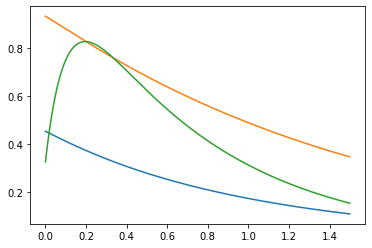

In [103]:
t = np.arange(0, 1.5, 0.001)
plt.plot(t, x_int)

In [54]:
## SPLITTING DATA

# This maintains the proportion used in the paper:
# Azencot, O., Erichson, N. B., Lin, V., & Mahoney, M. W. (2020). Forecasting sequential data using consistent Koopman autoencoders. arXiv preprint arXiv:2003.02236.
n_instances = int((600/1700) * x_int.shape[0])

# Splitting data into training and testing sets
x_train = x_int[:n_instances, ]
x_test = x_int[n_instances:, ]

# Scaling data with scikit learn scaler
scaler = MinMaxScaler();
scaler.fit(x_train);

scaled_train = scaler.transform(x_train)
scaled_test = scaler.transform(x_test)

# Using keras TimeseriesGenerator to generate batches for training and testing

# Length of the output sequences (in number of timesteps)
length = 49 
# Number of timeseries samples in each batch
batch_size = 1

train_generator = TimeseriesGenerator(scaled_train, scaled_train, length = length, batch_size = batch_size)
test_generator = TimeseriesGenerator(scaled_test, scaled_test, length = length, batch_size = batch_size)

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import RNN, Dense, LSTM, LSTMCell
from tensorflow.keras.callbacks import EarlyStopping
from architectures_v1 import *

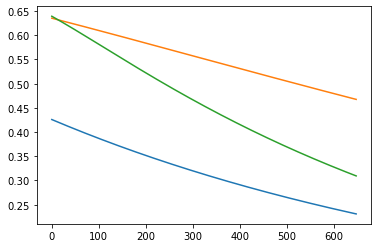

In [57]:
plt.plot(x_test)

In [8]:
batch_0 = train_generator[0]
x, y = batch_0

In [19]:
# Setting seed
seed = 10
tf.random.set_random_seed(seed)
np.random.seed(seed)

n_features = 2
early_stop = EarlyStopping(monitor = 'val_mean_absolute_error', patience = 1)

model = Sequential()
model.add(LSTM(units = 50, input_shape = (length, n_features)))
#model.add(RNN(LadderCell(units = 50,
#                            max_delay = 200,
#                            input_dims = n_features), input_shape = (length, n_features)))

# Final Prediction
model.add(Dense(n_features))

model.compile(optimizer='adam', loss = 'mse', metrics=[tf.keras.metrics.MeanAbsoluteError()])

model.summary()

hist = model.fit_generator(train_generator, epochs = 20, callbacks = [early_stop], validation_data = test_generator)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 50)                10600     
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 102       
Total params: 10,702
Trainable params: 10,702
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
551/551 [==============================] - 22s 40ms/step - loss: 0.0285 - mean_absolute_error: 0.0749 - val_loss: 1.5649e-05 - val_mean_absolute_error: 0.0029
Epoch 2/20
551/551 [==============================] - 20s 37ms/step - loss: 2.1344e-05 - mean_absolute_error: 0.0036 - val_loss: 3.3107e-05 - val_mean_absolute_error: 0.0047


In [20]:
df_hist = pd.DataFrame(data = hist.history)
df_hist

,loss,mean_absolute_error,val_loss,val_mean_absolute_error
0,0.028453,0.074880,0.000016,0.002882
1,0.000021,0.003574,0.000033,0.004715


In [8]:
# Extracting the number of states from the given data
n_states = x_test.shape[-1]
test_prediction = dict.fromkeys(np.arange(1, n_states + 1, 1))

# Adding an empty list to each state
for state in test_prediction:
    test_prediction[state] = []

# Take the last part of the training set as the first input to evaluate the network
first_eval_batch = scaled_train[-length:]
print(f'first_eval_batch: {first_eval_batch.shape}')

# Reshape the first evaluation batch to have the compatible shape (n_minibatches, length, n_features)
current_batch = first_eval_batch.reshape((1, length, n_features))
print(f'current_batch: {current_batch.shape}')

error = np.zeros_like(x_test)

for k in range(len(x_test)):
    
    # Compute prediction 1 time stamp ahead ([0] is for grabbing just the array values instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    for n_state, state in enumerate(current_pred):
        test_prediction[n_state + 1].append(state)
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1: ,:],[[current_pred]], axis = 1)

df_test_predictions = pd.DataFrame(columns = np.arange(1, n_states + 1, 1))

for state in test_prediction:    
    df_test_predictions[state] = np.asarray(test_prediction[state])
    
test_predictions = scaler.inverse_transform(df_test_predictions.values)

# Error computation
for k in range(1, len(x_test)):
    #print(test_predictions[:k, ].shape)
    error[k] = np.linalg.norm(test_predictions[:k, ] - x_test[:k, ]) / np.linalg.norm(x_test[:k, ])

first_eval_batch: (49, 2)
current_batch: (1, 49, 2)


In [45]:
(0.223 + 0.158 )/ 2

0.1905

In [37]:
pd.DataFrame(data = x_test)

,0,1
0,-0.240673,2.319405
1,-0.000851,2.438145
2,0.239053,2.321031
3,0.456037,1.985330
4,0.630315,1.475892
...,...,...
1095,0.695684,-1.178909
1096,0.548104,-1.753122
1097,0.349942,-2.180977
1098,0.118567,-2.409763


In [56]:
(0.638 + 0.220)/2

0.429

In [15]:
np.linalg.norm(x_test)

59.69033396647217

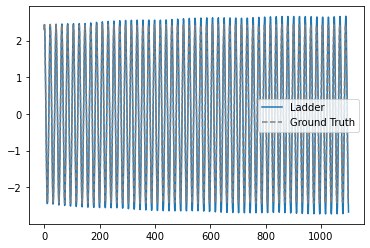

In [12]:
plt.plot(test_predictions[:, 1], label = "Ladder")
plt.plot(x_test[:, 1], label = "Ground Truth", linestyle = '--', color = 'grey')
plt.legend()

In [55]:
tf.keras.backend.clear_session()

In [ ]:
np.linalg.norm??

In [54]:
error[-1]

array([0.63853479, 0.63853479])